## Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import numpy as np


# Custome functions
sys.path.append('../scripts/python')
from taxonomic_composition_tables import adjust_suthaus_2020_df, prepare_data_for_plotting, plot_taxonomic_data

/home/lubo/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Global variables

In [2]:
project = 'Suthaus_2022'
cell = 'cellCombined'
marker = 'Full18S'
sim = 'sim90'
denoise_method = 'RAD'
raw_data = os.path.join('..', 'raw_data')
tax_assign_results = os.path.join(raw_data, 'tax_assign_results', project, marker, cell, sim, denoise_method)
otu_results = os.path.join(raw_data, 'OTU_results', project)

# Creating taxonomic table

In [ ]:
# VARIABLES

project = 'Jamy_2022'
cell = 'cell'
marker = 'rDNA'
sim = 'sim97'
raw_data = '../raw_data'
tax_assign_results =  f'{raw_data}/tax_assign_results/{project}/{marker}/{cell}/{sim}'
otu_results = f'{raw_data}/OTU_results/{project}'

In [ ]:
# get paths

files = os.listdir(tax_assign_results)
paths = [tax_assign_results + '/' + file for file in files]

record = {'otu_id': [], 
          'abundance': [],
          'kingdom': [], 
          'domain': [], 
          'phyllum': [], 
          'class': [], 
          'order': [], 
          'family': [], 
          'genus': [], 
          'species': [], 
          'closest_match': [],
          'percent_identity': [], 
          'sample': []}
    
for path in paths:
    with open(path, 'rt') as f:
        lines = f.readlines()
        for line in lines:
            record['otu_id'].append(line.split('\t')[0])
            record['abundance'].append(line.split('\t')[0].split('=')[-1])
            tax_assign = line.split('\t')[1]
            record['kingdom'].append(tax_assign.split(',')[0].split(':')[1])
            record['domain'].append(tax_assign.split(',')[1].lstrip('d:'))
            record['phyllum'].append(tax_assign.split(',')[2].lstrip('p:'))
            record['class'].append(tax_assign.split(',')[3].lstrip('c:'))
            record['order'].append(tax_assign.split(',')[4].lstrip('o:'))
            record['family'].append(tax_assign.split(',')[5].lstrip('f:'))
            record['genus'].append(tax_assign.split(',')[6].lstrip('g:'))
            record['species'].append(tax_assign.split(',')[7].lstrip('s:'))
            record['closest_match'].append(line.split('\t')[1].split(';')[0].split('.')[0])
            record['percent_identity'].append(line.split('\t')[2])
            record['sample'].append(path.split('/')[-1].lstrip('blast6_').rstrip('.tab'))

        
sum_table = pd.DataFrame.from_dict(record)

In [ ]:
# removing the '_21R' from all the sample names if present (this applied for Suthaus 2022 rDNA data)
sum_table['sample'] = sum_table['sample'].str.replace('_21R','')

In [ ]:
sum_table_filtered = sum_table[sum_table['abundance'] != '1']

In [ ]:
# save the summary table as excel tables

sum_table.to_excel(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}.xlsx')

In [ ]:
# save the summary table as tsv tables

sum_table.to_csv(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}.tsv', sep = '\t')

In [ ]:
# save the filtered summary table as tsv tables

sum_table_filtered.to_csv(f'{otu_results}/OTU_summary_table_{marker}_{cell}_{sim}_filtered.tsv', sep = '\t')

# Creating final taxonomic table

## DataFrame

Read all the files from the tax_assign_results directory and concatenate them into a single DataFrame

In [3]:
# 1. List all files in the directory
files = [f for f in os.listdir(tax_assign_results) if f.endswith('.tab')]

# 2. Iterate over each file
dfs = []

for f in files:
    # extract sample name
    sample_name = f.split('_')[1]
    # Load file into DataFrame
    df = pd.read_csv(f'{tax_assign_results}/{f}', sep='\t', header=None)
    # Add a new column for sample name
    df['Sample'] = sample_name
    dfs.append(df)

# 3. Concatenate all DataFrames
all_samples = pd.concat(dfs, ignore_index=True)

# 4. Dataframe adjustments
all_samples = adjust_suthaus_2020_df(all_samples)

In [ ]:
all_samples.head(5)

In [ ]:
all_samples['Sample'].unique()

In [ ]:
# Save the DataFrame to CSV
output_filename = f'final_tax_table_{marker}_{sim}.csv'
output_path = os.path.join(otu_results, output_filename)

all_samples.to_csv(output_path, index=False)

In [4]:
# Save the DataFrame to Excel
output_filename = f'final_tax_table_{marker}_{sim}.xlsx'
output_path = os.path.join(otu_results, output_filename)

all_samples.to_excel(output_path, index=True, engine='openpyxl')

# Taxonomic composition plots

## Variables

In [40]:
grouping = 'unique_otus' # Options: 'unique_otus' or 'abundances'
taxonomic_level = 'Domain' # Taxonomic level for the plotting
threshold_percentage = 3 # Set the percentage treshold based on what the tax. groups will be grouped together as 'Others'
save_path = os.path.join(otu_results, f'tax_composition_{taxonomic_level}_{grouping}_{marker}_{sim}.png')
load_data_path = os.path.join(otu_results, f'final_tax_table_{marker}_{sim}.csv')

# Define the new sample names if you want to change it in the plot
sample_name_mapping = {'deep_sea_A3': 'Deep Sea A3', 
                       'deep_sea_X17007': 'Deep Sea X17007', 
                       'NH1': 'Neuenhähnen 1', 
                       'NH4': 'Neuenhähnen 4', 
                       'Sim17': 'Simmelried 17', 
                       'Sim22': 'Simmelried 22', 
                       'Th16': 'Thielenbruch 16', 
                       'Th38': 'Thielenbruch 38',
                       'Th40': 'Thielenbruch 40',}

## Loading data

In [168]:
all_samples = pd.read_csv(load_data_path)

In [201]:
all_samples['Domain'].value_counts()

Opisthokonta      224
Alveolata         200
Rhizaria          150
Stramenopiles      74
Amoebozoa          66
Archaeplastida     61
Excavata           60
Hacrobia           10
Apusozoa            3
Archaea_X           1
Bacteria_X          1
Eukaryota_X         1
Name: Domain, dtype: int64

In [11]:
all_samples['Domain'].unique()

array(['SAR', 'Opisthokonta', 'Amoebozoa', 'Archaeplastida', 'Excavata',
       'Hacrobia', 'Archaea_X', 'Bacteria_X', 'Apusozoa', 'Eukaryota_X'],
      dtype=object)

In [10]:
# OPTIONAL
# grouping to SAR

# Define a dictionary with current names as keys and new names as values
replacement_dict = {
    'Stramenopiles': 'SAR',
    'Alveolata': 'SAR',
    'Rhizaria': 'SAR'
}

# Replace values in the 'Domain' column based on the dictionary
all_samples['Domain'] = all_samples['Domain'].replace(replacement_dict)

## Filtering out unwanted samples and taxonomic groups

In [170]:
# Filter out the 'Mock' sample, 'Bacteria_X' domain, and 'Metazoa' phyllum
filtered_samples = all_samples[(all_samples['Sample'] != 'Mock') 
                               & (all_samples['Domain'] != 'Bacteria_X') 
                               & (all_samples['Domain'] != 'Eukaryota_X') 
                               & (all_samples['Phyllum'] != 'Metazoa')]

## Preparing data for plotting

In [38]:
# Preparing data for plotting
pivot_table, excluded_columns = prepare_data_for_plotting(dataframe = filtered_samples, 
                                                          taxonomic_level = taxonomic_level, 
                                                          threshold_percentage = threshold_percentage, grouping = grouping)

## Plotting & Saving

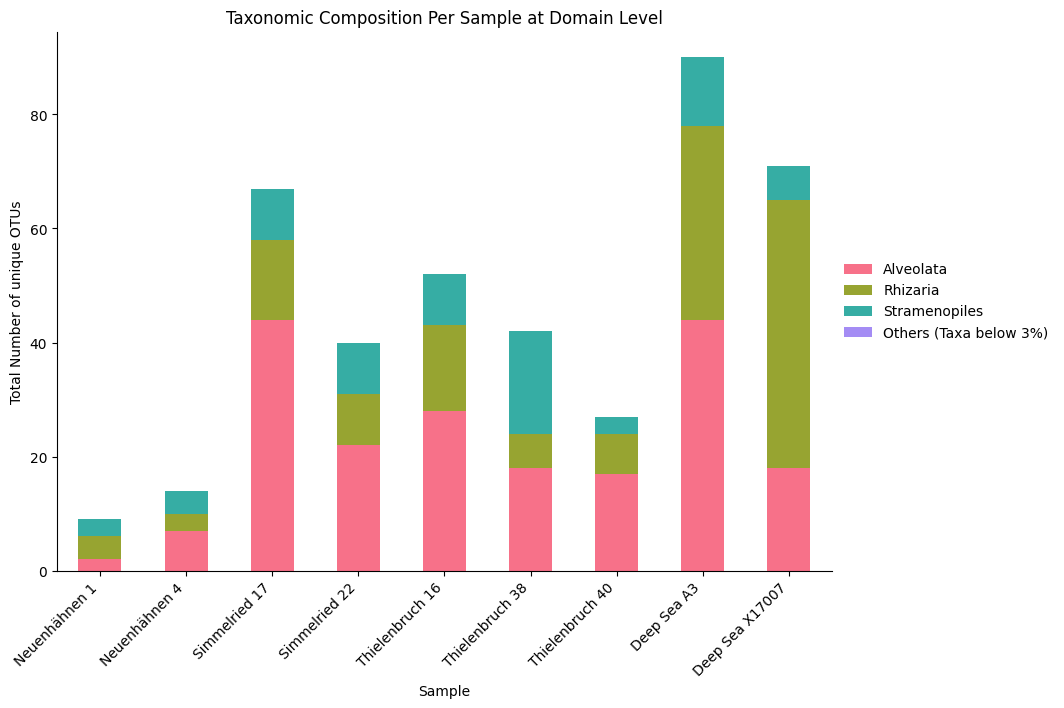

In [39]:
plot_taxonomic_data(pivot_table, 
                    excluded_columns, 
                    taxonomic_level = taxonomic_level, 
                    grouping= grouping, 
                    sample_name_mapping = sample_name_mapping,
                    save_path = save_path)

# Taxonomic composition plots: Subgrouping

Examining taxonomic composition within a specific group

## Variables

In [31]:
all_samples['Domain']

0                 SAR
1                 SAR
2                 SAR
3                 SAR
4                 SAR
            ...      
846         Amoebozoa
847      Opisthokonta
848    Archaeplastida
849         Amoebozoa
850    Archaeplastida
Name: Domain, Length: 851, dtype: object

In [278]:
grouping = 'unique_otus' # Options: 'unique_otus' or 'abundances'
taxonomic_level = 'Phyllum' # Taxonomic level for the plotting
threshold_percentage = 0 # Set the percentage treshold based on what the tax. groups will be grouped together as 'Others'

# Subgrouping Option:
# If you wish to further examine the taxonomic composition within a specific group, 
# provide the specific taxa and its corresponding taxonomic level.
taxa_specific = 'Apusozoa' 
taxa_specific_level = 'Domain' 

load_data_path = os.path.join(otu_results, f'final_tax_table_{marker}_{sim}.csv')
save_path = os.path.join(otu_results, f'tax_composition_{taxonomic_level}_{grouping}_{marker}_{sim}_{taxa_specific}.png')

# Define the new sample names if you want to change it in the plot
sample_name_mapping = {'deep_sea_A3': 'Deep Sea A3', 
                       'deep_sea_X17007': 'Deep Sea X17007', 
                       'NH1': 'Neuenhähnen 1', 
                       'NH4': 'Neuenhähnen 4', 
                       'Sim17': 'Simmelried 17', 
                       'Sim22': 'Simmelried 22', 
                       'Th16': 'Thielenbruch 16', 
                       'Th38': 'Thielenbruch 38',
                       'Th40': 'Thielenbruch 40',}

## Loading data

In [279]:
all_samples = pd.read_csv(load_data_path)

## Selecting specific taxonomic group

In [280]:
# Filter the samples based on the specified taxonomic group and its level.
subgrouped_samples = all_samples[all_samples[taxa_specific_level] == taxa_specific]

In [281]:
subgrouped_samples

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
227,seq108_12,2,JQ340334.1.1799_U,Eukaryota,Apusozoa,Hilomonadea,Planomonadida,Planomonadidae,Planomonadidae_Group1,Planomonas,Planomonas_brevis,85.6,1766,deep_sea_A3
239,seq151_28,1,JQ340335.1.1776_U,Eukaryota,Apusozoa,Hilomonadea,Planomonadida,Planomonadidae,Planomonadidae_Group1,Fabomonas,Fabomonas_tropica,90.0,1757,deep_sea_A3
760,seq288_13,1,EU349234.1.1778_U,Eukaryota,Apusozoa,Hilomonadea,Planomonadida,Planomonadidae,Planomonadidae_Group1,Ancyromonas,Ancyromonas_howeae,99.9,1751,Th16


## Filtering out unwanted samples and taxonomic groups

In [282]:
# Filter out the 'Mock' sample, 'Bacteria_X' domain, and 'Metazoa' phyllum
filtered_samples = subgrouped_samples[(subgrouped_samples['Sample'] != 'Mock') 
                                      & (subgrouped_samples['Domain'] != 'Bacteria_X') 
                                      & (subgrouped_samples['Phyllum'] != 'Metazoa')]

## Preparing data for plotting

In [283]:
# Preparing data for plotting
pivot_table, excluded_columns = prepare_data_for_plotting(dataframe = filtered_samples, 
                                                          taxonomic_level = taxonomic_level, 
                                                          threshold_percentage = threshold_percentage, grouping = grouping)

## Plotting

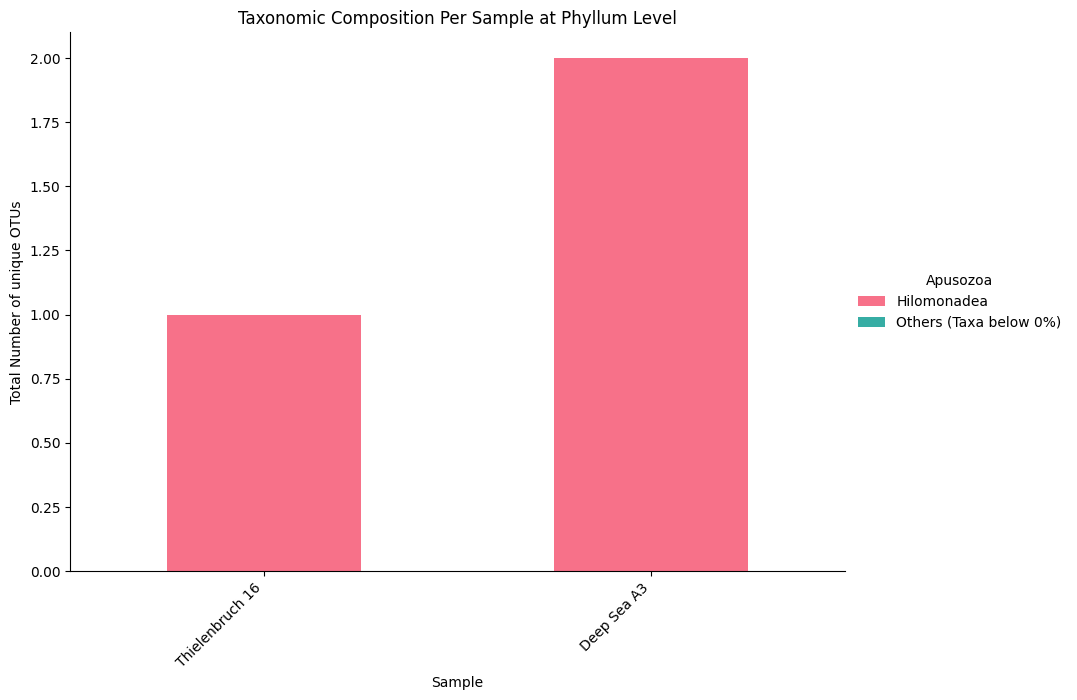

In [284]:
plot_taxonomic_data(pivot_table, 
                    excluded_columns, 
                    taxonomic_level = taxonomic_level, 
                    grouping= grouping, 
                    sample_name_mapping = sample_name_mapping,
                    save_path = save_path, 
                    subgroup = taxa_specific)

# Stats (Optional)

In [ ]:
taxon = 'Hacrobia'

In [286]:
apusozoa = filtered_samples[filtered_samples['Domain'] == 'Apusozoa']
# stramenopiles = stramenopiles[(stramenopiles['Sample'] != 'Mock')]

In [287]:
apusozoa['Sample'].unique()

array(['deep_sea_A3', 'Th16'], dtype=object)

In [288]:
apusozoa

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
227,seq108_12,2,JQ340334.1.1799_U,Eukaryota,Apusozoa,Hilomonadea,Planomonadida,Planomonadidae,Planomonadidae_Group1,Planomonas,Planomonas_brevis,85.6,1766,deep_sea_A3
239,seq151_28,1,JQ340335.1.1776_U,Eukaryota,Apusozoa,Hilomonadea,Planomonadida,Planomonadidae,Planomonadidae_Group1,Fabomonas,Fabomonas_tropica,90.0,1757,deep_sea_A3
760,seq288_13,1,EU349234.1.1778_U,Eukaryota,Apusozoa,Hilomonadea,Planomonadida,Planomonadidae,Planomonadidae_Group1,Ancyromonas,Ancyromonas_howeae,99.9,1751,Th16


In [272]:
hacrobia['Species'].value_counts()

Cryptomonas_pyrenoidifera    3
Cryptomonas_sp.              2
Katablepharidales_XX_sp.     1
TelonemiaGroup1_X_sp.        1
Diacronema_noctivaga         1
Chroomonas_mesostigmatica    1
Pterocystis_sp.              1
Name: Species, dtype: int64

In [128]:
stramenopiles[stramenopiles['Phyllum'] == 'Cercozoa']['Class'].value_counts()

Endomyxa                57
FilosaSarcomonadea      30
FilosaImbricatea        11
EndomyxaAscetosporea     9
FilosaThecofilosea       5
Novelclade1012           3
FilosaGranofilosea       1
Chlorarachniophyceae     1
EndomyxaPhytomyxea       1
Filosa                   1
Name: Class, dtype: int64

In [273]:
hacrobia[hacrobia['Species'] == 'Cryptomonas_pyrenoidifera']

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
78,seq80_48,1,AF508267.1.1726_U,Eukaryota,Hacrobia,Cryptophyta,Cryptophyceae,Cryptomonadales,Cryptomonadales_X,Cryptomonas,Cryptomonas_pyrenoidifera,99.8,1724,Th38
142,seq193_24,1,AF508267.1.1726_U,Eukaryota,Hacrobia,Cryptophyta,Cryptophyceae,Cryptomonadales,Cryptomonadales_X,Cryptomonas,Cryptomonas_pyrenoidifera,99.5,1724,Sim22
558,seq153_9,1,AF508267.1.1726_U,Eukaryota,Hacrobia,Cryptophyta,Cryptophyceae,Cryptomonadales,Cryptomonadales_X,Cryptomonas,Cryptomonas_pyrenoidifera,98.1,1727,NH4


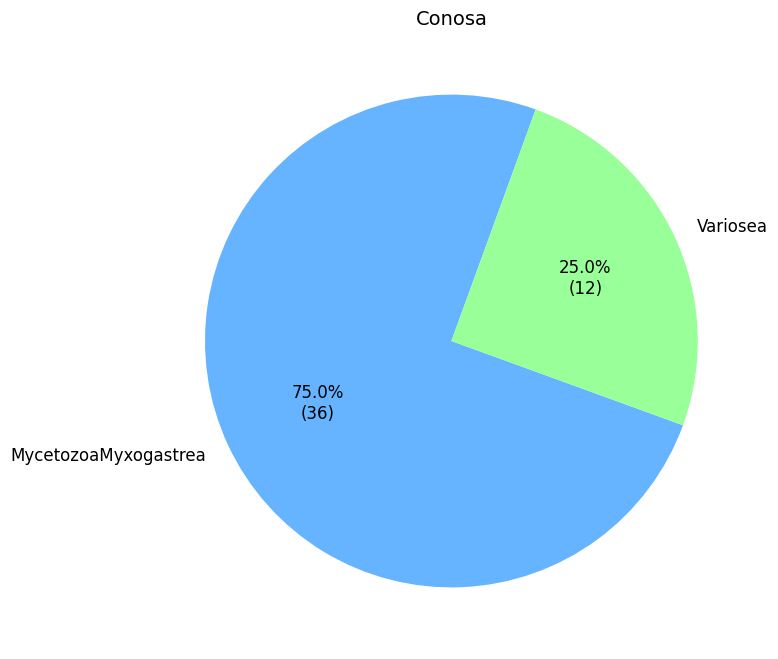

In [256]:
# Get value counts
phyllum_counts = conosa['Class'].value_counts()

# Define autopct function with increased font size
def func(pct, allvalues): 
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Plot
plt.figure(figsize=(8,8))
phyllum_counts.plot(kind='pie', 
                    autopct=lambda pct: func(pct, phyllum_counts),
                    startangle=70, 
                    colors=['#66b3ff','#99ff99','#ffcc99', '#c2c2f0','#ffb3e6'],
                    textprops={'fontsize': 12})  # Adjust font size here
plt.title('Lobosa', fontsize=14)  # Adjust title font size here
plt.ylabel('')  # Hide the y-label which would be 'None' by default

# Save the plot
plt.savefig(os.path.join(otu_results, 'phyllum_distribution_conosa.png'), dpi=300, bbox_inches='tight')

plt.show()


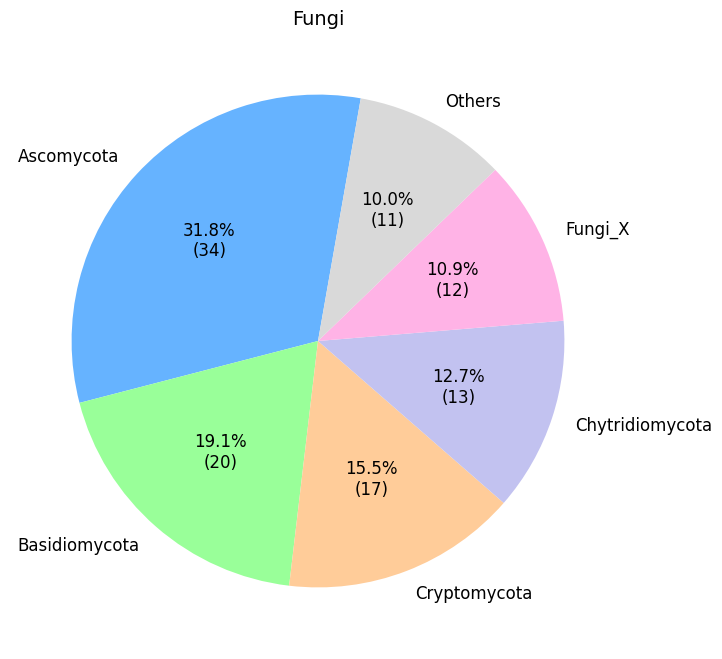

In [186]:
import matplotlib.pyplot as plt

# Get value counts
phyllum_counts = fungi['Class'].value_counts()

# Set threshold for small percentages
threshold = 5  # Set your threshold percentage value
threshold_count = sum(phyllum_counts) * (threshold / 100)  # Convert threshold to count

# Filter out small percentages and aggregate into 'Others'
small_percentages = phyllum_counts[phyllum_counts <= threshold_count]
other_count = sum(small_percentages)
adjusted_phyllum_counts = phyllum_counts[phyllum_counts > threshold_count]
adjusted_phyllum_counts['Others'] = other_count  # Add 'Others' category to Series

# Define autopct function with increased font size
def func(pct, allvalues): 
    absolute = int(pct/100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Plot
plt.figure(figsize=(8,8))
adjusted_phyllum_counts.plot(kind='pie', 
                             autopct=lambda pct: func(pct, adjusted_phyllum_counts),
                             startangle=80, 
                             colors=['#66b3ff','#99ff99','#ffcc99', '#c2c2f0','#ffb3e6', '#d9d9d9'],  # Add more colors if needed
                             textprops={'fontsize': 12})  # Adjust font size here
plt.title('Fungi', fontsize=14)  # Adjust title font size here
plt.ylabel('')  # Hide the y-label which would be 'None' by default

# Save the plot
plt.savefig(os.path.join(otu_results, 'phyllum_distribution_fungi.png'), dpi=300, bbox_inches='tight')

plt.show()


In [42]:
# OPTIONAL
# filter rows keeping only SAR group

# Define a list of the values you want to filter for
filter_values = ['Stramenopiles', 'Alveolata', 'Rhizaria']

# Filter the DataFrame to contain only rows where the 'Domain' column value is in the filter_values list
filtered_samples = all_samples[all_samples['Domain'].isin(filter_values)]

# Finding common taxa

## Finding common taxa across samples

In [4]:
# Variables
load_data_path = os.path.join(otu_results, f'final_tax_table_{marker}_{sim}.csv')

In [5]:
# Loading data
all_samples = pd.read_csv(load_data_path)

In [8]:
# Check the dataframe
all_samples.head(3)

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
0,seq106_27,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,94.5,683,Th38
1,seq150_65,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,95.1,884,Th38
2,seq104_29,6,DQ462456.1.1771_U,Eukaryota,Alveolata,Apicomplexa,Gregarinomorphea,Neogregarinorida,Actinocephalidae,Ascogregarina,Ascogregarina_culicis,84.0,1748,Th38


In [11]:
# Check all the samples included
all_samples['Sample'].unique()

array(['Th38', 'Mock', 'Sim22', 'deep_sea_A3', 'Th40', 'Sim17', 'NH4',
       'deep_sea_X17007', 'Th16', 'NH1'], dtype=object)

In [10]:
# Filter out the 'Mock' sample, 'Bacteria_X' domain, and 'Metazoa' phyllum
filtered_samples = all_samples[(all_samples['Sample'] != 'Mock') 
                               & (all_samples['Domain'] != 'Bacteria_X') 
                               & (all_samples['Domain'] != 'Eukaryota_X') 
                               & (all_samples['Phyllum'] != 'Metazoa')]

In [12]:
# Check all the samples after filtering the mock community
filtered_samples['Sample'].unique()

array(['Th38', 'Sim22', 'deep_sea_A3', 'Th40', 'Sim17', 'NH4',
       'deep_sea_X17007', 'Th16', 'NH1'], dtype=object)

In [13]:
filtered_samples

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
0,seq106_27,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,94.5,683,Th38
1,seq150_65,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,95.1,884,Th38
2,seq104_29,6,DQ462456.1.1771_U,Eukaryota,Alveolata,Apicomplexa,Gregarinomorphea,Neogregarinorida,Actinocephalidae,Ascogregarina,Ascogregarina_culicis,84.0,1748,Th38
3,seq213_14,1,KC511080,Eukaryota,Rhizaria,Cercozoa,Endomyxa,Vampyrellida,Leptophryidae,Leptophryidae_X,Leptophryidae_XX,92.2,641,Th38
4,seq222_12,1,EF165122.1.1785_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeE,Chrysophyceae_CladeE_X,Chrysophyceae_CladeE_X_sp.,91.0,662,Th38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,seq68_32,7,AJ252294.1.1819_U,Eukaryota,Archaeplastida,Streptophyta,Embryophyceae,Embryophyceae_X,Embryophyceae_XX,Exsertotheca,Exsertotheca_crispa,99.6,1774,NH1
846,seq85_97,1,JQ031960.1.6974_G,Eukaryota,Amoebozoa,Conosa,MycetozoaMyxogastrea,StemonitalesPhysarales,StemonitalesPhysarales_X,Colloderma,Colloderma_robustum,94.9,723,NH1
848,seq73_19,2,AB013175.1.3767_U,Eukaryota,Archaeplastida,Rhodophyta,Bangiophyceae,Bangiales,Bangiaceae,Pyropia,Pyropia_tenera,84.4,1777,NH1
849,seq72_22,1,HE614616.1.7859_U,Eukaryota,Amoebozoa,Conosa,MycetozoaMyxogastrea,StemonitalesPhysarales,Didymiaceae,Diderma,Diderma_niveum,92.2,1236,NH1


Now, we want to find out which taxa (for example, at the species level) is the most dominant/present across all the samples. Let's say I have a made-up species named *Cosmopolitanus vulgaris* and this species was present in all my samples, so I want to order all the species that are present the most across the samples. Below is the step-by-step approach:

1. **Group by Species**: We need to group the data by 'Species' so that we can perform operations on each group of species.

2. **Count Unique Samples**: Within each group, count the number of unique samples that each species is found in.

3. **Sort the Results**: Sort the counts in descending order so we can see the species that are found in the most samples at the top.

In [14]:
# Group by 'Species', and count the number of unique samples for each species
species_counts = filtered_samples.groupby('Species')['Sample'].nunique().reset_index(name='sample_count')

In [16]:
# Sort the result in descending order based on the sample_count
species_counts = species_counts.sort_values(by='sample_count', ascending=False)

In [18]:
species_counts.head(20)

,Species,sample_count
85,Diderma_niveum,8
126,Fungi_XXXX_sp.,7
168,Lepidoderma_tigrinum,7
196,Monocystis_sp.,6
128,Giardia_intestinalis,6
179,MAST12C_XX_sp.,5
98,Dinophyceae_XXX_sp.,5
309,SpizellomycetalesandRhizophlyctidales_sp.,5
6,Allapsidae_X_sp.,5
75,Cryptomycotina_XX_sp.,5


In [19]:
# check the 10 most common species in the original dataframe

# Get the species names from the first 10 rows of the species_counts DataFrame
top_species_names = species_counts['Species'].head(10).tolist()

# Filter the all_samples DataFrame to include only rows where the 'Species' value is in top_species_names
top_species_in_original_df = filtered_samples[filtered_samples['Species'].isin(top_species_names)]

In [40]:
top_species_in_original_df[top_species_in_original_df['Species'] == 'Giardia_intestinalis']

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
135,seq125_19,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,92.7,910,Sim22
275,seq178_35,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,81.3,2114,deep_sea_A3
431,seq114_58,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,89.2,1270,Sim17
591,seq118_11,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,92.4,917,deep_sea_X17007
677,seq60_21,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,89.6,1198,deep_sea_X17007
679,seq48_24,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,89.8,1254,deep_sea_X17007
750,seq270_72,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,93.9,730,Th16
819,seq140_11,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,87.9,1440,NH1
834,seq46_49,1,X52949.1.5566_U,Eukaryota,Excavata,Metamonada,Fornicata_X,Diplomonadida,Hexamitidae,Giardia,Giardia_intestinalis,94.1,703,NH1


## Finding common taxa within samples

In [41]:
filtered_samples

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
0,seq106_27,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,94.5,683,Th38
1,seq150_65,1,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,95.1,884,Th38
2,seq104_29,6,DQ462456.1.1771_U,Eukaryota,Alveolata,Apicomplexa,Gregarinomorphea,Neogregarinorida,Actinocephalidae,Ascogregarina,Ascogregarina_culicis,84.0,1748,Th38
3,seq213_14,1,KC511080,Eukaryota,Rhizaria,Cercozoa,Endomyxa,Vampyrellida,Leptophryidae,Leptophryidae_X,Leptophryidae_XX,92.2,641,Th38
4,seq222_12,1,EF165122.1.1785_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeE,Chrysophyceae_CladeE_X,Chrysophyceae_CladeE_X_sp.,91.0,662,Th38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,seq68_32,7,AJ252294.1.1819_U,Eukaryota,Archaeplastida,Streptophyta,Embryophyceae,Embryophyceae_X,Embryophyceae_XX,Exsertotheca,Exsertotheca_crispa,99.6,1774,NH1
846,seq85_97,1,JQ031960.1.6974_G,Eukaryota,Amoebozoa,Conosa,MycetozoaMyxogastrea,StemonitalesPhysarales,StemonitalesPhysarales_X,Colloderma,Colloderma_robustum,94.9,723,NH1
848,seq73_19,2,AB013175.1.3767_U,Eukaryota,Archaeplastida,Rhodophyta,Bangiophyceae,Bangiales,Bangiaceae,Pyropia,Pyropia_tenera,84.4,1777,NH1
849,seq72_22,1,HE614616.1.7859_U,Eukaryota,Amoebozoa,Conosa,MycetozoaMyxogastrea,StemonitalesPhysarales,Didymiaceae,Diderma,Diderma_niveum,92.2,1236,NH1


In [43]:
filtered_samples.sort_values(by='OTU_Num', ascending=False).head(20)

,OTU,OTU_Num,Reference_ID,Kingdom,Domain,Phyllum,Class,Order,Family,Genus,Species,Pident,Length,Sample
844,seq49_42,80,AB454198.1.1771_U,Eukaryota,Opisthokonta,Fungi,Ascomycota,Pezizomycotina,Dothideomycetes,Botryosphaeria,Botryosphaeria_dothidea,98.0,1753,NH1
13,seq125_29,65,EF165145.1.1730_U,Eukaryota,Stramenopiles,Ochrophyta,Chrysophyceae,Chrysophyceae_X,Chrysophyceae_CladeB1,Chrysocapsa,Chrysocapsa_wetherbeei,98.8,1730,Th38
566,seq187_8,58,AB454198.1.1771_U,Eukaryota,Opisthokonta,Fungi,Ascomycota,Pezizomycotina,Dothideomycetes,Botryosphaeria,Botryosphaeria_dothidea,98.2,1753,NH4
823,seq192_17,56,JX169826.1.1778_U,Eukaryota,Archaeplastida,Chlorophyta,Trebouxiophyceae,WatanabeaClade,WatanabeaClade_X,Apatococcus,Apatococcus_lobatus,98.3,1754,NH1
16,seq180_18,44,AF164131.1.1772_U,Eukaryota,Alveolata,Ciliophora,Spirotrichea,Hypotrichia,Urostylidae,Uroleptus,Uroleptus_pisces,98.8,1724,Th38
700,seq123_45,40,DQ384071.1.1738_U,Eukaryota,Opisthokonta,Fungi,Ascomycota,Pezizomycotina,Dothideomycetes,Ulospora,Ulospora_bilgramii,98.3,1738,Th16
570,seq194_6,36,KM020050.1.1779_U,Eukaryota,Archaeplastida,Chlorophyta,Trebouxiophyceae,Trebouxiophyceae_X,Trebouxiophyceae_XX,Pseudococcomyxa,Pseudococcomyxa_sp.,98.2,1753,NH4
457,seq238_24,35,AM114821.1.1792_U,Eukaryota,Archaeplastida,Chlorophyta,Chlorophyceae,Chlamydomonadales,Chlamydomonadales_X,Chlamydomonadales_XX,Chlamydomonadales_XX_sp.,97.2,1751,Sim17
319,seq338_6,34,HQ699895.1.1774_U,Eukaryota,Alveolata,Ciliophora,Spirotrichea,Hypotrichia,Oxytrichidae,Bistichella,Bistichella_variabilis,97.7,1731,deep_sea_A3
445,seq189_20,33,AM412766.1.1730_U,Eukaryota,Alveolata,Ciliophora,Spirotrichea,Hypotrichia,Oxytrichidae,Oxytricha,Oxytricha_longigranulosa,99.2,1730,Sim17


In [60]:
abundance_counts_per_sample = filtered_samples.sort_values(by='OTU_Num', ascending=False)[['Species', 'OTU_Num', 'Phyllum', 'Class', 'Sample']].head(20)

In [61]:
abundance_counts_per_sample

,Species,OTU_Num,Phyllum,Class,Sample
844,Botryosphaeria_dothidea,80,Fungi,Ascomycota,NH1
13,Chrysocapsa_wetherbeei,65,Ochrophyta,Chrysophyceae,Th38
566,Botryosphaeria_dothidea,58,Fungi,Ascomycota,NH4
823,Apatococcus_lobatus,56,Chlorophyta,Trebouxiophyceae,NH1
16,Uroleptus_pisces,44,Ciliophora,Spirotrichea,Th38
700,Ulospora_bilgramii,40,Fungi,Ascomycota,Th16
570,Pseudococcomyxa_sp.,36,Chlorophyta,Trebouxiophyceae,NH4
457,Chlamydomonadales_XX_sp.,35,Chlorophyta,Chlorophyceae,Sim17
319,Bistichella_variabilis,34,Ciliophora,Spirotrichea,deep_sea_A3
445,Oxytricha_longigranulosa,33,Ciliophora,Spirotrichea,Sim17


In [49]:
# Group by 'Species' and sum 'OTU_num' within each group
abundance_counts = filtered_samples.groupby('Species')['OTU_Num'].sum().reset_index(name='total_abundance')

# Sort the result in descending order based on total_abundance
abundance_counts = abundance_counts.sort_values(by='total_abundance', ascending=False)

# If you want to view the result
abundance_counts.head(20)  # This will print the top 10 rows

,Species,total_abundance
29,Botryosphaeria_dothidea,161
45,Chlamydomonadales_XX_sp.,111
54,Chrysocapsa_wetherbeei,100
118,Filoreta_sp.,91
196,Monocystis_sp.,69
25,Bistichella_variabilis,62
242,Pentapharsodinium_tyrrhenicum,58
13,Apatococcus_lobatus,56
209,Nidula_niveotomentosa,54
98,Dinophyceae_XXX_sp.,52


In [57]:
# Group by 'Species', and for each group, aggregate 'OTU_num' by sum and other columns by first
aggregated_df = filtered_samples.groupby('Species').agg({
    'OTU_Num': 'sum',  # Sum OTU_num within each group
    'Phyllum': 'first',
    'Class': 'first',  
    'Sample': lambda x: ', '.join(x.unique())  # Join unique 'Sample' values within each group
}).reset_index()

# Sort the result in descending order based on aggregated OTU_num
abundance_counts_with_other_columns = aggregated_df.sort_values(by='OTU_Num', ascending=False)

# If you want to view the result
abundance_counts_with_other_columns.head(20)  # This will print the top 10 rows


,Species,OTU_Num,Phyllum,Class,Sample
29,Botryosphaeria_dothidea,161,Fungi,Ascomycota,"Th40, NH4, NH1"
45,Chlamydomonadales_XX_sp.,111,Chlorophyta,Chlorophyceae,"Th38, Sim22, Sim17, Th16"
54,Chrysocapsa_wetherbeei,100,Ochrophyta,Chrysophyceae,"Th38, NH1"
118,Filoreta_sp.,91,Cercozoa,Endomyxa,"deep_sea_A3, deep_sea_X17007"
196,Monocystis_sp.,69,Apicomplexa,Gregarinomorphea,"Th38, Th40, Sim17, NH4, Th16, NH1"
25,Bistichella_variabilis,62,Ciliophora,Spirotrichea,"Sim22, deep_sea_A3, Th40, Th16"
242,Pentapharsodinium_tyrrhenicum,58,Dinoflagellata,Dinophyceae,"Sim22, Sim17"
13,Apatococcus_lobatus,56,Chlorophyta,Trebouxiophyceae,NH1
209,Nidula_niveotomentosa,54,Fungi,Basidiomycota,"Th40, NH4"
98,Dinophyceae_XXX_sp.,52,Dinoflagellata,Dinophyceae,"Th38, deep_sea_A3, Sim17, deep_sea_X17007, Th16"


# Test the long tail pattern

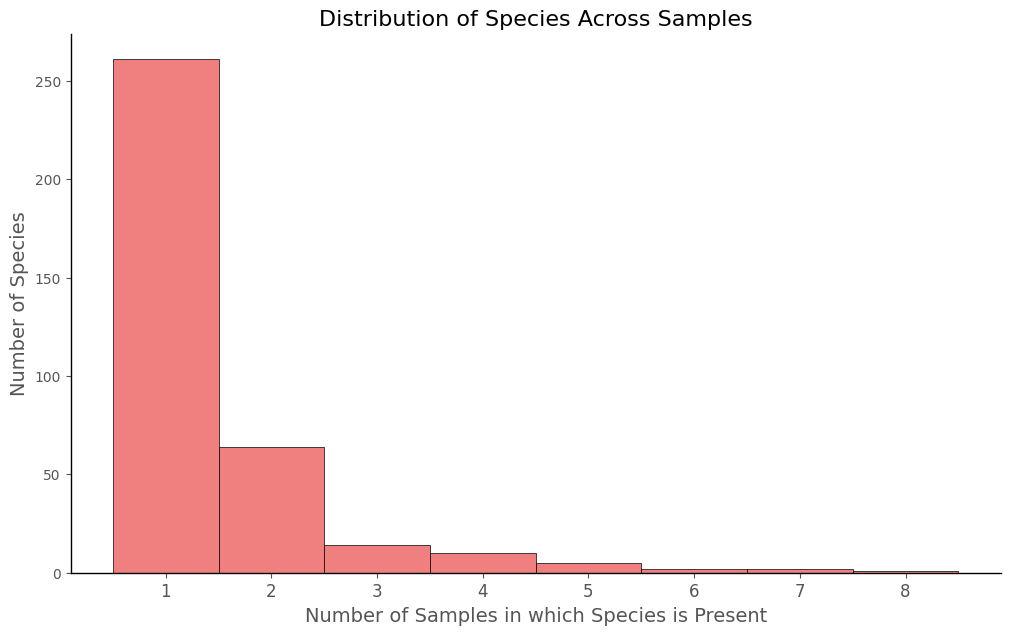

In [92]:
# save path
save_path = os.path.join(otu_results, f'species_distribution_{marker}_{sim}.png')

# Plot histogram with enhancements
plt.figure(figsize=(12,7))

# Histogram with specified color and transparency
counts, bins, patches = plt.hist(species_counts['sample_count'], bins=range(1, species_counts['sample_count'].max() + 2), 
                                edgecolor='black', color='lightcoral')

# Set x-ticks to be at the middle of each bin
plt.xticks(np.array(bins)[:-1] + 0.5)

# Set x-tick labels to be integers and adjust font size
plt.gca().set_xticklabels(range(1, species_counts['sample_count'].max() + 1), fontsize=12)

# Set background color to white
plt.gca().set_facecolor('white')

# Set visibility for spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

# Set colors for visible spines
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')

# Labeling the plot with adjusted font size
plt.title('Distribution of Species Across Samples', fontsize=16)
plt.xlabel('Number of Samples in which Species is Present', fontsize=14)
plt.ylabel('Number of Species', fontsize=14)

# # Display the plot
# plt.show()


# Save the figure
plt.savefig(save_path, dpi=300, bbox_inches='tight')